## Robust Mean - Variance Portfolio

Consider the problem of allocating  to allocate a capital over multiple assets to maximize portfolio's expected return, while ensuring a very low probability that the actual return falls below the computed value. This approach addresses the inherent uncertainty in portfolio returns, making it a robust optimization problem.

In the example taken from [1, Section 3.4], we have $n = 200$ assets. Let $r_i$ denote the return, and $\sigma_i$ denote the standard deviation associated with the $i$-th asset. The last asset represents cash, so we set its return to $r_{n}=1.05$ and standard deviation to $\sigma_n = 0$. The returns of the remaining assets $r_i$, for $i=1,\dots, n-1$, are random variables taking values in the intervals $[\mu_i - \sigma_i ,\mu_i + \sigma_i  ]$. The vectors $\mu$ and $\sigma$ are defined as

$$ \mu_i = 1.05 + \frac{0.3\left(n - i\right)}{n - 1} , \quad \sigma_i = 0.05 + \frac{0.6\left(n - i\right)}{n - 1}, \quad i=1,\dots,n-1. $$



To solve this problem, we first import the required packages and generate the data. 

In [2]:
import lropt
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
n = 200
cash_return = 1.05

#Define mu
mu = np.zeros(n)
mu[-1] = cash_return
for i in range(n - 1):
    mu[i] = cash_return + 0.3 * (n - i) / (n- 1) 

#Define sigma
sigma = np.zeros(n)
for i in range(n - 1):
    sigma[i] = 0.05 + 0.6 * (n - i) / (n - 1)

The problem we want to solve is the uncertain linear optimization problem of the form
$$\begin{array}{ll}
\text{maximize} & t \\
\text{subject to} & r^Tx \geq t \quad \forall r \in \mathcal{U} \\
                  & 1^T x= 1 \\
                  & x \geq 0,
\end{array}$$
where $x_i$ is the normalized capital to be invested in asset $i$, and $r$ is the uncertain vector of returns. We model the uncertain returns as $r_i = \mu_i + \sigma_i z_i$ for $i=1,\dots,n$, where $z = (z_1,\dots,z_n)$ is a vector of uncertain parameters. In the following snippet, we solve this problem using Ellipsoidal and Budget uncertainty sets of the form:
$$\begin{array}{ll}
&\mathcal{U}_{\rm ellip} = \{ r = \mu + {\bf diag}(\sigma) z \mid \|z\|_2 \le \rho \}\\
&\mathcal{U}_{\rm budg} = \{ r = \mu + {\bf diag}(\sigma) z \mid \|z\|_{\infty} \le \rho,\; \|z\|_{1} \le \rho \},\\
\end{array}
$$
for different values of the set radius $\rho$.


In [4]:
names = ['Ellipsoidal', 'Budget']
rho_values = np.linspace(0.1, 2.0, 10)  # Range of rho values

uncertainty_sets = {
    'ellipsoidal': lambda rho: lropt.Ellipsoidal(rho=rho, b=mu, a=np.diag(sigma)),
    'budget': lambda rho: lropt.Budget(rho1=rho, rho2=rho, b=mu, a=np.diag(sigma))
}

results = {}
for uc_name, uc in uncertainty_sets.items():
    
    results_uc = []
    for rho in rho_values:
        t = cp.Variable()
        x = cp.Variable(n)
        r = lropt.UncertainParameter(n, uncertainty_set=uc(rho))

        constraints = [
            r @ x >= t,
            cp.sum(x) == 1,
            x >= 0
        ]

        objective = cp.Maximize(t)
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()

        optimal_allocation = x.value
        optimal_return = t.value

        # Estimates of covariance and risk based on simplified model
        cov_matrix = np.diag(sigma ** 2)
        variance = np.dot(optimal_allocation.T, np.dot(cov_matrix, optimal_allocation))
        risk = np.sqrt(variance)

        results_uc.append({
            'rho': rho,
            'return': optimal_return,
            'risk': risk
        })

    results[uc_name] = pd.DataFrame(results_uc)

The following code creates a graph of the tradeoff curve of risk and return over a range of values of $\rho$.

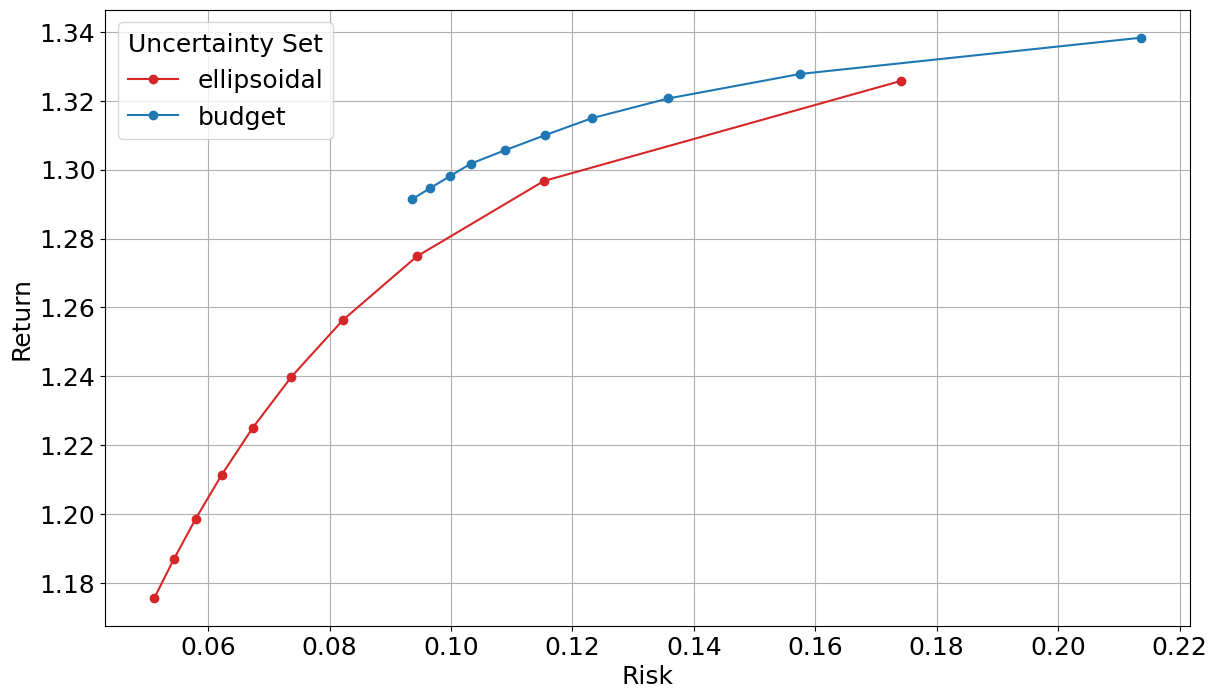

In [5]:
plt.figure(figsize=(14, 8))
plt.rcParams.update({"font.size": 18})
colors = ['tab:red', 'tab:blue']

for idx, uc in enumerate(uncertainty_sets.keys()):
    plt.plot(results[uc]['risk'], results[uc]['return'], color=colors[idx], marker='o', label=uc)

plt.xlabel('Risk')
plt.ylabel('Return')
plt.legend(title='Uncertainty Set')
plt.grid(True)
plt.show()

# References

1. Bertsimas, Dimitris, and Dick Den Hertog. Robust and Adaptive Optimization. [Dynamic Ideas LLC], 2022.